In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
import unicodedata
from thefuzz import process
from data.references import reference_dict

# 1. Load Pre-Processed Data

In [2]:
# Read in prepared literature overview
df = pd.read_excel('literature_review_results.xlsx')

# Add authors short version
df['authors_short'] = df['authors'].apply(lambda x: f"({x.split(',')[0]} et al.)")

# Add recency metric
df['submittion_date_arXiv'] = pd.to_datetime(df['submittion_date_arXiv'])

# Calculate the difference in days between the date in the DataFrame and the newest submittion
df['days_diff'] = (df['submittion_date_arXiv'].max() - df['submittion_date_arXiv']).dt.days

# Normalize the 'days_diff' column to a range between 0 and 1
df['newness'] = (df['days_diff'] - df['days_diff'].min()) / (df['days_diff'].max() - df['days_diff'].min())
df['newness'] = 1 - df['newness']  # Invert to give more relevance to newer publications

df.drop(columns='days_diff', inplace=True)

In [3]:
df.head()

,publication_year,submittion_date_arXiv,authors,title,title_formatted,proposed_framework,framework_short_name,citations_27_03_2024,Abstract Note,authors_short,newness
0,2023,2023-02-21,"White, Jules; Fu, Quchen; Hays, Sam; Sandborn,...",A Prompt Pattern Catalog to Enhance Prompt Eng...,a prompt pattern catalog to enhance prompt eng...,Prompt Patterns,Prompt Patterns,484,Prompt engineering is an increasingly importan...,(White et al.),0.815583
1,2022,2022-11-08,"Zhang, Yiming; Feng, Shi; Tan, Chenhao",Active Example Selection for In-Context Learning,active example selection for in-context learning,In-Context Example Selection,IC Example Selection,87,"With a handful of demonstration examples, larg...",(Zhang et al.),0.756726
2,2022,2022-03-21,"Sorensen, Taylor; Robinson, Joshua; Rytting, C...",An Information-theoretic Approach to Prompt En...,an information-theoretic approach to prompt en...,Prompt Templates Selection Based on Mutual Inf...,MI Template Selection,94,Pre-trained language models derive substantial...,(Sorensen et al.),0.626682
3,2023,2023-03-16,"Paranjape, Bhargavi; Lundberg, Scott; Singh, S...",ART: Automatic multi-step reasoning and tool-u...,art: automatic multi-step reasoning and tool-u...,Automatic multi-step Reasoning and Tool-use (ART),ART,90,Large language models (LLMs) can perform compl...,(Paranjape et al.),0.828475
4,2023,2022-10-05,"Arora, Simran; Narayan, Avanika; Chen, Mayee F...",Ask Me Anything: A simple strategy for prompti...,ask me anything: a simple strategy for prompti...,Ask Me Anything (AMA),AMA,116,Large language models (LLMs) transfer well to ...,(Arora et al.),0.737668
...,...,...,...,...,...,...,...,...,...,...,...
84,2023,2023-05-17,"Yao, Shunyu; Yu, Dian; Zhao, Jeffrey; Shafran,...",Tree of Thoughts: Deliberate Problem Solving w...,tree of thoughts: deliberate problem solving w...,Tree of Thoughts (ToT),ToT,657,Language models are increasingly being deploye...,(Yao et al.),0.863229
85,2023,2023-05-07,"Li, Xiaonan; Lv, Kai; Yan, Hang; Lin, Tianyang...",Unified Demonstration Retriever for In-Context...,unified demonstration retriever for in-context...,Unified Demonstration Retriever (UDR),UDR,36,In-context learning is a new learning paradigm...,(Li et al.),0.857623
86,2023,2023-05-05,"Zhao, Ruochen; Li, Xingxuan; Joty, Shafiq; Qin...",Verify-and-Edit: A Knowledge-Enhanced Chain-of...,verify-and-edit: a knowledge-enhanced chain-of...,Verify-and-Edit,V-and-E,46,As large language models (LLMs) have become th...,(Zhao et al.),0.856502
87,2022,2021-01-17,"Liu, Jiachang; Shen, Dinghan; Zhang, Yizhe; Do...",What Makes Good In-Context Examples for GPT-3?,what makes good in-context examples for gpt-3?,Semantically Similar IC Example Retrieval,IC Example Selection,750,GPT-3 has attracted lots of attention due to i...,(Liu et al.),0.386771


In [4]:
def preprocess_title(title):
    # Remove double spaces
    title = re.sub(r'\s+', ' ', title)
    # Remove special non-ASCII characters
    title = ''.join(char for char in title if unicodedata.category(char)[0] != 'C')
    # Convert to lowercase
    title = title.lower()
    return title

In [5]:
def fuzzy_filter_and_replace(dictionary, threshold=95):
    filtered_dict = {}
    keys = list(dictionary.keys())

    for key, titles in dictionary.items():
        filtered_titles = []
        for title in titles:
            match, score = process.extractOne(title, keys)
            if score >= threshold:
                # Replace the title with the corresponding key
                filtered_titles.append(match)
        filtered_dict[key] = filtered_titles

    return filtered_dict

In [6]:
preprocessed_dict = {preprocess_title(k): [preprocess_title(v) for v in vals] for k, vals in reference_dict.items()}
filtered_dict = fuzzy_filter_and_replace(preprocessed_dict)

In [7]:
# Create nummeric mapping
title_to_number = {k: i for i, k in enumerate(filtered_dict.keys())}
number_to_title = {v: k for k, v in title_to_number.items()}

# replace string values in filtered dict with numeric values
nummeric_dict = {title_to_number[k]: [title_to_number[v] for v in vals] for k, vals in filtered_dict.items()}

## Helper Functions

In [8]:
def get_papers_referencing_x(paper_name: str) -> list[str]:
    """Retrieves papers that cite a given paper"""
    paper_idx = title_to_number[paper_name]
    papers_referencing = [k for k, v in nummeric_dict.items() if paper_idx in v]
    return [number_to_title[v] for v in papers_referencing]

In [9]:
get_papers_referencing_x("react: synergizing reasoning and acting in language models")

['multitool-cot: gpt-3 can use multiple external tools with chain of thought prompting',
 'batch prompting: efficient inference with large language model apis',
 'hierarchical prompting assists large language model on web navigation',
 'verify-and-edit: a knowledge-enhanced chain-of-thought framework',
 'reflexion: language agents with verbal reinforcement learning',
 'graph of thoughts: solving elaborate problems with large language models',
 'tree of thoughts: deliberate problem solving with large language models',
 'pearl: prompting large language models to plan and execute actions over long documents',
 'pal: program-aided language models',
 'measuring and narrowing the compositionality gap in language models',
 'plan-and-solve prompting: improving zero-shot chain-of-thought reasoning by large language models',
 'skeleton-of-thought: prompting llms for efficient parallel generation',
 'chain-of-knowledge: grounding large language models via dynamic knowledge adapting over heterogen

# Citation Network Analysis

In [10]:
# Create citation graph
G = nx.DiGraph(nummeric_dict)

In [95]:
# Calculate closeness centrality as a measure of influence
centrality = nx.closeness_centrality(G)

# Map it back to the title
title_centrality = {number_to_title[k]: v for k, v in centrality.items()}

# Add it to the df
df['influence'] = df['title_formatted'].map(title_centrality)

# Scale it to 0 and 1
df.loc[:, 'influence'] = (df['influence'] - df['influence'].min()) / (df['influence'].max() - df['influence'].min())

In [96]:
# Calculate betweenness centrality as a measure of future impact
centrality = nx.betweenness_centrality(G)

# Map it back to the title
title_centrality = {number_to_title[k]: v for k, v in centrality.items()}

# Add it to the df
df['future_importance'] = df['title_formatted'].map(title_centrality)

# Scale it to 0 and 1
df.loc[:, 'future_importance'] = (df['future_importance'] - df['future_importance'].min()) / (df['future_importance'].max() - df['future_importance'].min())

In [97]:
def visualize_graph_with_closeness_centrality(
    graph: nx.Graph,
    top_n: int = 15,
    k: int = 3,
    threshold: float = 0.01
) -> None:
    """Visualizes the Network."""
    # Calculate centrality
    centrality = nx.closeness_centrality(G)
    
    # Sort nodes based on centrality
    sorted_nodes = sorted(centrality, key=centrality.get, reverse=True)
    
    # Exclude nodes with centrality very close to 0
    filtered_nodes = [node for node in sorted_nodes if centrality[node] > threshold]
    
    # Select top n nodes for labeling
    top_nodes = filtered_nodes[:top_n]
    
    # Create a subgraph containing only the desired nodes and edges
    subgraph = graph.subgraph(filtered_nodes)
    node_sizes = [centrality[node] * 5000 for node in subgraph.nodes() if node in filtered_nodes]

    # Draw the graph
    plt.figure(figsize=(12, 8))

    pos = nx.spring_layout(subgraph, k=k, iterations=5000)

    nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color=[centrality[node] for node in subgraph.nodes()], alpha=0.75, cmap=plt.cm.viridis)
    nx.draw_networkx_labels(subgraph, pos, labels={node: node if node in top_nodes else '' for node in subgraph.nodes()}, font_size=8)
    nx.draw_networkx_edges(subgraph, pos, width=0.5, alpha=0.75, edge_color='grey', arrowsize=5)
    
    # Remove axes
    plt.axis('off')
    
    # Show the plot
    plt.show()

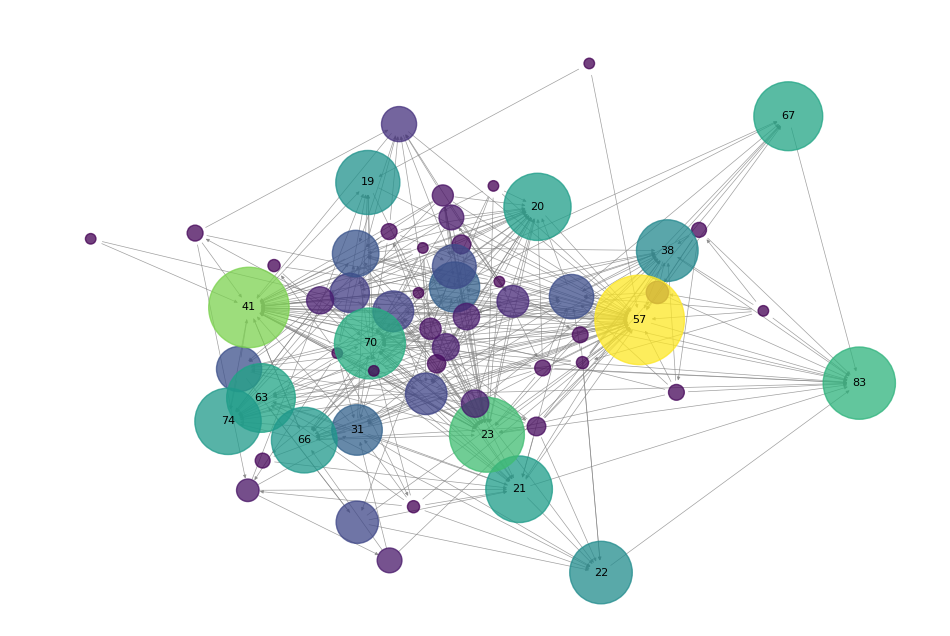

In [98]:
# Visualize the closeness centrality of the graph
visualize_graph_with_closeness_centrality(G)

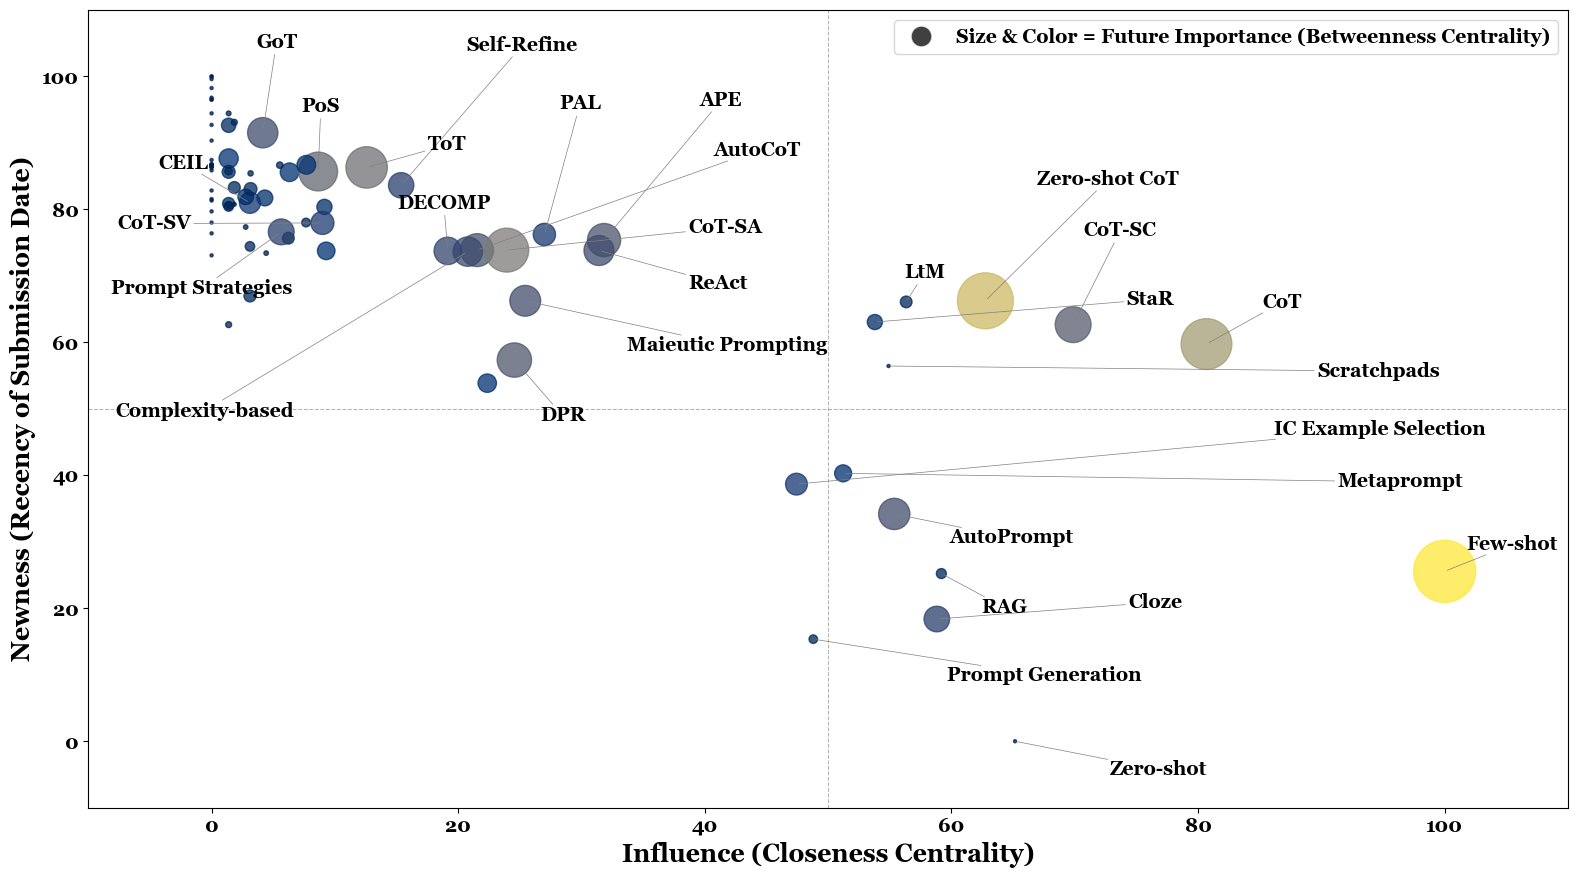

In [118]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from adjustText import adjust_text
from matplotlib.lines import Line2D

# Set the font properties globally for all text in the plot
plt.rcParams['font.size'] = 14  # Adjust to your preference
plt.rcParams['font.weight'] = 'bold'  # Make the text bold
plt.rcParams['font.family'] = 'Georgia'

fig, ax = plt.subplots()
fig.set_size_inches(16, 9)

sc = ax.scatter(df['influence'] * 100, df['newness'] * 100, c=df['future_importance'], s=df['future_importance'] * 2_000 + 5, alpha=0.75, cmap=plt.cm.cividis)

# Setting limits
ax.set_xlim(-10, 110)
ax.set_ylim(-10, 110)

# Adding horizontal and vertical lines
ax.axhline(y=50, color='dimgray', linestyle='--', lw=0.75, alpha=0.5)
ax.axvline(x=50, color='dimgray', linestyle='--', lw=0.75, alpha=0.5)

# Assuming you have added annotations to a list
texts = []
for idx, row in df.iterrows():
    if (row['future_importance'] > 0.1) or (row['influence'] > 0.3):
        texts.append(ax.annotate(row['framework_short_name'], (row['influence'] * 100, row['newness'] * 100)))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5), explode_radius=4, expand=(2.5, 2.5))

# Setting axis labels with specific font adjustments
ax.set_xlabel('Influence (Closeness Centrality)', fontsize=18, fontweight='bold', fontfamily='Georgia')
ax.set_ylabel('Newness (Recency of Submission Date)', fontsize=18, fontweight='bold', fontfamily='Georgia')

# Adjusting the tick labels' font size and weight
ax.tick_params(axis='both', which='major', labelsize=14)

# Improving the layout for a more scientific look
plt.tight_layout()

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Size & Color = Future Importance (Betweenness Centrality)',
                          markerfacecolor='black', markersize=15, alpha=0.75)]
ax.legend(handles=legend_elements, loc='upper right')

plt.show()

In [ ]:
# Export the results to an excel for further analysis
df_sorted = df.sort_values(by=['influence', 'newness', 'citations_27_03_2024'], ascending=False)
df_sorted.to_excel('network_analysis_results.xlsx', index=False)

# Alternative Visualization

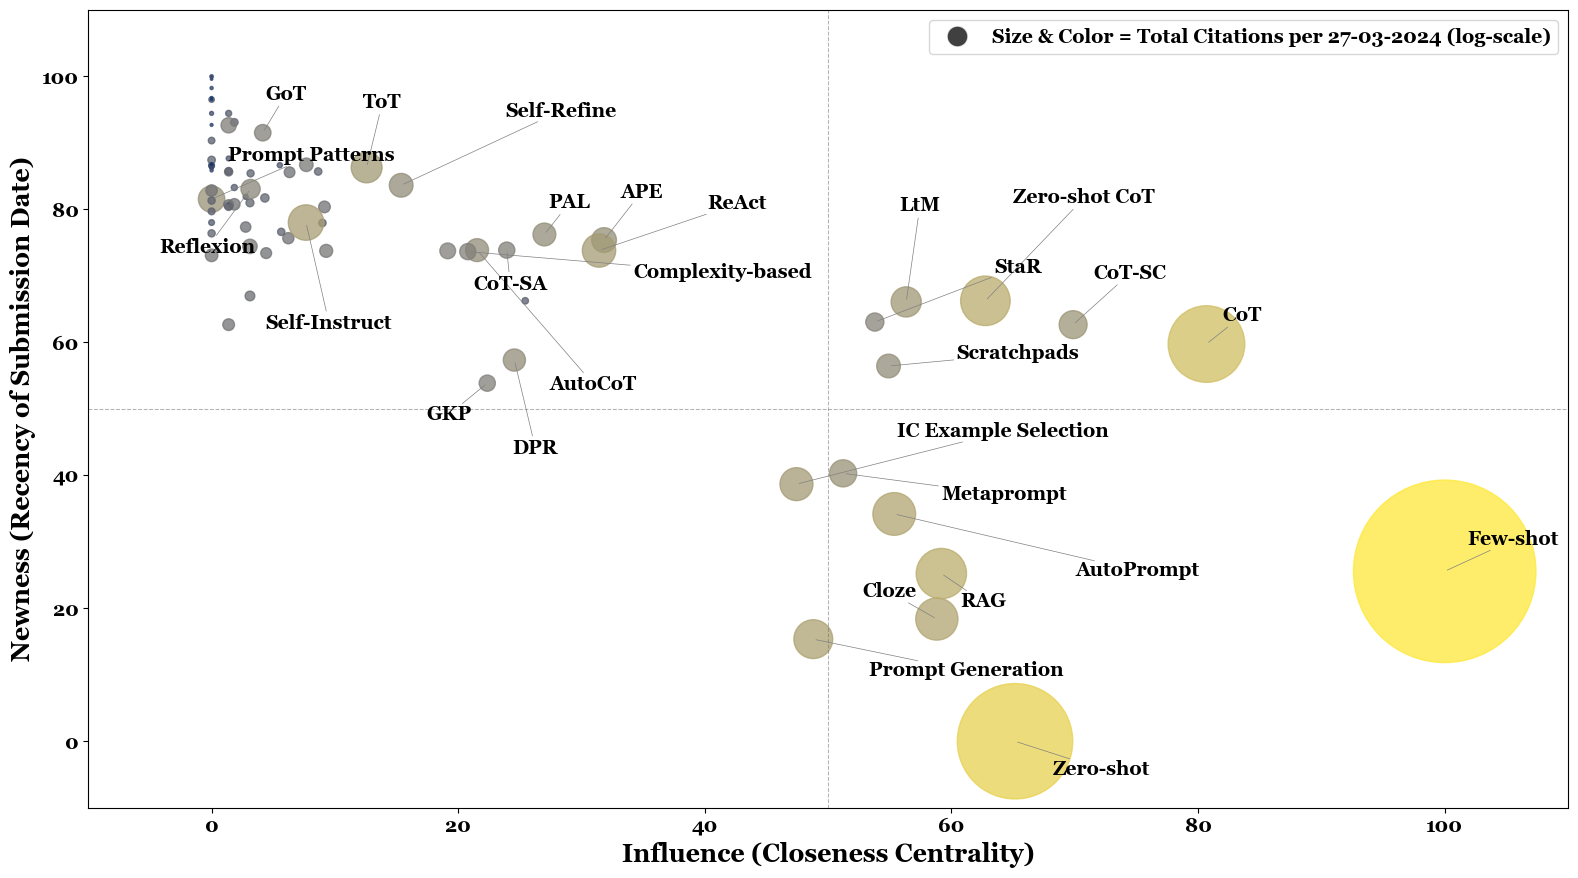

In [99]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from adjustText import adjust_text
from matplotlib.lines import Line2D

plt.rcParams['font.size'] = 14  # Adjust to your preference
plt.rcParams['font.weight'] = 'bold'  # Make the text bold
plt.rcParams['font.family'] = 'Georgia'

fig, ax = plt.subplots()
fig.set_size_inches(16, 9)

log_norm = LogNorm(vmin=df['citations_27_03_2024'].min(), vmax=df['citations_27_03_2024'].max())
sc = ax.scatter(df['influence'] * 100, df['newness'] * 100, c=df['citations_27_03_2024'], s=df['citations_27_03_2024'] * 0.75, alpha=0.75, cmap=plt.cm.cividis, norm=log_norm)

# Setting limits
ax.set_xlim(-10, 110)
ax.set_ylim(-10, 110)

# Adding horizontal and vertical lines
ax.axhline(y=50, color='dimgray', linestyle='--', lw=0.75, alpha=0.5)
ax.axvline(x=50, color='dimgray', linestyle='--', lw=0.75, alpha=0.5)

# Assuming you have added annotations to a list
texts = []
for idx, row in df.iterrows():
    if (row['citations_27_03_2024'] >= 180):
        texts.append(ax.annotate(row['framework_short_name'], (row['influence'] * 100, row['newness'] * 100)))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5), explode_radius=3, expand=(1.5, 3))

# Setting axis labels with specific font adjustments
ax.set_xlabel('Influence (Closeness Centrality)', fontsize=18, fontweight='bold', fontfamily='Georgia')
ax.set_ylabel('Newness (Recency of Submission Date)', fontsize=18, fontweight='bold', fontfamily='Georgia')

# Adjusting the tick labels' font size and weight
ax.tick_params(axis='both', which='major', labelsize=14)

# Improving the layout for a more scientific look
plt.tight_layout()

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Size & Color = Total Citations per 27-03-2024 (log-scale)',
                          markerfacecolor='black', markersize=15, alpha=0.75)]
ax.legend(handles=legend_elements, loc='upper right')

plt.show()